### ASTR 3300/ PHYS 5300-003: Astrostatistics
***N. Pol***
___

# Homework 7
### Due: Friday, Apr. 4, at 11.59pm CT
---

This is a regression problem. Many of the parts require minor variations of code to switch to new techniques, but otherwise using a similar workflow. 

Note of warning: the data I have provided have associated uncertainties, `yerr`. `sklearn` and `astroML` have different formats for using uncertainties; in `sklearn` fitting you can provide `sample_weight=1/yerr**2`, while in `astroML` fitting you can directly provide `y_error=yerr`.

1. Read in `hw7_data_1.npy`. The dataset should consist of $500$ samples. The first two columns are the two data features, `X`. The third column is the target labels, `y`, and the final column are the heteroscedastic uncertainties on the labels, `yerr`. Make a 2-panel scatter plot of the labels versus each feature.


2. Use multivariate linear regression on this data with its uncertainties (`astroML` rather than plain `sklearn` is the better option here). Print the best-fit intercept and slopes for the features. Make a prediction `Xgrid` over $50$ values from the min to the max value of each feature, and plot the best-fit model on a duplicate of the $2$-panel plot from (1); does this look like a good description of the data?


3. Make a new two-dimensional prediction meshgrid `Xgrid` over the $2$-D feature space, use your best-fit model to predict the labels, and make a $3$-D interactive plot showing the data and your best-fit over the entire space. You may find the following code useful.

In [ ]:
# install the relevant interactive plot packages
# only do this once
!pip install ipywidgets ipympl

In [ ]:
# Makes the plot interactive. 
# You can pan the image.

### always do this line at the start 
### of an interactive plotting cell
%matplotlib widget 
fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111, projection='3d')

ax.plot(___, ___, y, color='k', 
        zorder=15, linestyle='none', 
        marker='o', alpha=0.5)
ax.scatter(___.flatten(), ___.flatten(), ___, 
           facecolor=(0,0,0,0), s=20, 
           edgecolor='#70b3f0')
ax.set_xlabel('X[0]', fontsize=12)
ax.set_ylabel('X[1]', fontsize=12)
ax.set_zlabel('Target', fontsize=12)

ax.view_init(elev=28, azim=120)

In [ ]:
### Always do this line at the start
### of a static plotting cell
%matplotlib inline

4. Sticking with a linear model, now attempt a `GridSearchCV` procedure on the data to find the best `Ridge` regression hyper-parameters. Use the following `param_grid`:
```
ridge_params = {'alpha': [0.05,0.1,0.2,0.5,1.0], 'solver': ['svd', 'lsqr']}
```
What are the `best_params_` and the `best_score_` from this? Fit the data with the best options, and visualize interactively. Try `RidgeCV` also; what cross-validated `alpha_` does it return, and does this agree with `GridSeachCV`? *(Hint: remember to revert to inline matplotlib when you're done each time you make an interactive plot.)*


5. Now model the data using Gaussian process regression and the default kernel. Check what the fit looks like with and with and without uncertainties accounted for. *(Hint: GPR in `sklearn` takes an `alpha` parameter equal to `(yerr/y)**2`.)*


6. Let's look finally at polynomial fitting. Fit a $4$th degree polynomial to the data. Print the best-fit regression coefficients, predict on the 2D meshgrid, and visualize interactively as before. How does this look compared to the linear model and GPR models?


7. Sticking with polynomial fitting, let's find the optimal hyper-parameters through cross-validation. 
- Using `sklearn.model_selection.train_test_split`, first do a train-test split with a `test_size` of $20\%$. Then split out $20\%$ of the training set itself as a cross-validation set (leaving a somewhat smaller set to use for training). Note that you'll need to simultaneously split out `yerr` as well by just providing this as another array to `train_test_split`.
- Compute the training and cross-validation rms errors (and from those, the BIC values) as a function of polynomial degree from $1$ to $10$ inclusive. Plot the rms errors and BIC values as a function of the polynomial degree. 
- Choose the optimal polynomial degree, and train on all training data from the first `train_test_split` operation. Predict the labels of the held-out test set, and finally compute the testing rms error.

Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import ipympl
import sklearn.linear_model as l_m
from astroML.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error


C:\Users\jeell\anaconda3\Lib\site-packages\astroML\linear_model\linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


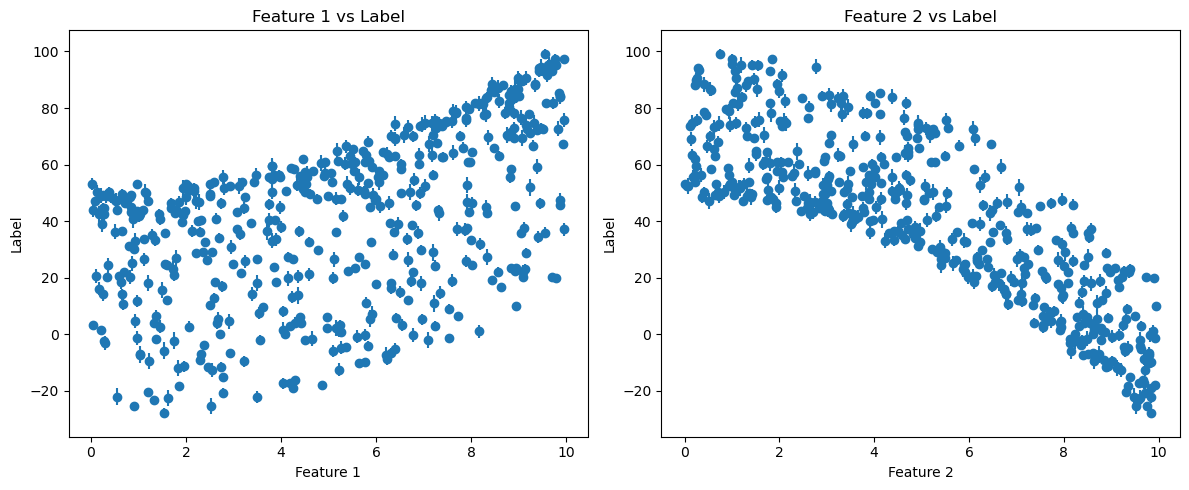

In [3]:
# Part 1
%matplotlib inline

data = np.load('C:/Users/jeell/OneDrive/Documents/GitHub/ASTR_3300_S2025/coursework/homeworks/hw_data/hw7_data_1.npy')
X = data[:,:2]
y = data[:,2]
yerr = data[:,3]
n_sam = X.shape[0]

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].errorbar(X[:,0], y, yerr=yerr, fmt='o')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Label')
axes[0].set_title('Feature 1 vs Label')
axes[1].errorbar(X[:,1], y, yerr=yerr, fmt='o')
axes[1].set_xlabel('Feature 2')
axes[1].set_ylabel('Label')
axes[1].set_title('Feature 2 vs Label')
plt.tight_layout()
plt.show()

AstroML Linear Regression:
Intercept: 57.101
Slope (Feature 1): 4.949
Slope (Feature 2): -8.300


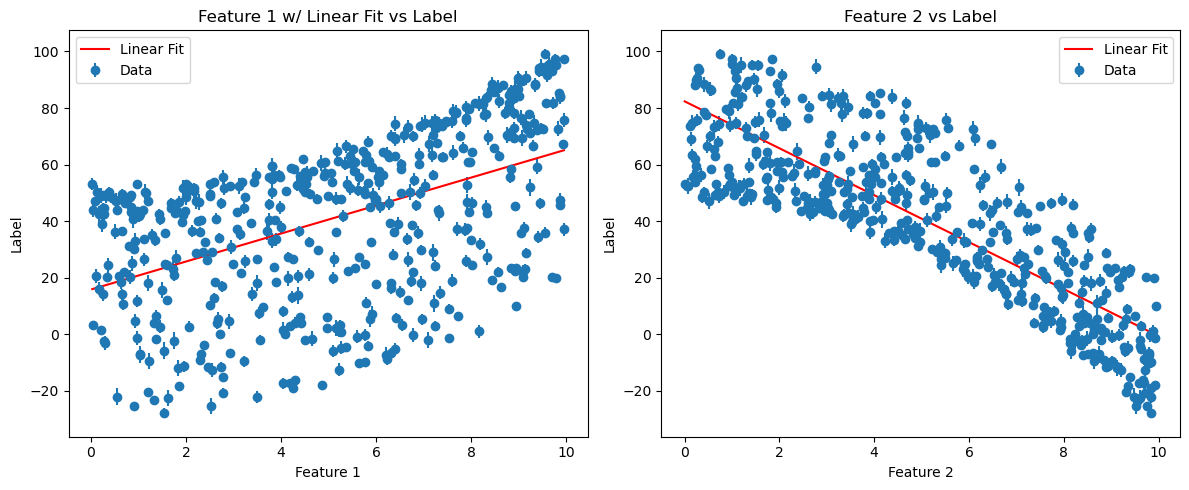


The model gets the general trend across but does not truly fit the data.


In [5]:
# Part 2
%matplotlib inline

l_aML = LinearRegression(fit_intercept=True)
l_aML.fit(X, y, y_error=yerr)

print("AstroML Linear Regression:")
print(f"Intercept: {l_aML.coef_[0]:.3f}")
print(f"Slope (Feature 1): {l_aML.coef_[1]:.3f}")
print(f"Slope (Feature 2): {l_aML.coef_[2]:.3f}")

x1_min, x1_max = X[:,0].min(), X[:,0].max()
x2_min, x2_max = X[:,1].min(), X[:,1].max()
x1_grid = np.linspace(x1_min, x1_max, 50)
x2_grid = np.linspace(x2_min, x2_max, 50)
Xgrid = np.array(np.meshgrid(x1_grid, x2_grid)).T.reshape(-1,2)
y_p_l = l_aML.predict(Xgrid)

fig, axes = plt.subplots(1, 2, figsize=(12,5))
axes[0].errorbar(X[:,0], y, yerr=yerr, fmt='o', label='Data')
axes[0].plot(x1_grid, l_aML.predict(np.c_[x1_grid, np.mean(X[:,1])*np.ones_like(x1_grid)]), 'r-', label='Linear Fit')
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Label')
axes[0].set_title('Feature 1 w/ Linear Fit vs Label')
axes[0].legend()

axes[1].errorbar(X[:,1], y, yerr=yerr, fmt='o', label='Data')
axes[1].plot(x2_grid, l_aML.predict(np.c_[np.mean(X[:,0])*np.ones_like(x2_grid), x2_grid]), 'r-', label='Linear Fit')
axes[1].set_xlabel('Feature 2')
axes[1].set_ylabel('Label')
axes[1].set_title('Feature 2 vs Label')
axes[1].legend()
plt.tight_layout()
plt.show()

print("\nThe model gets the general trend across but does not truly fit the data.")

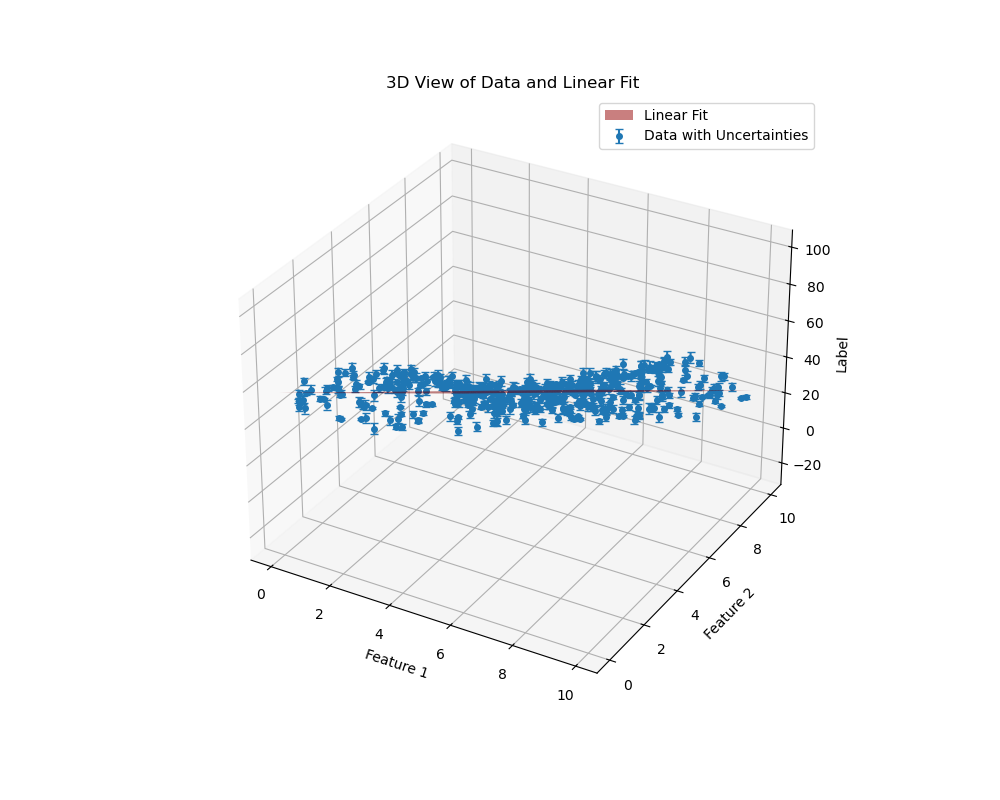

In [7]:
# Part 3
%matplotlib widget 

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.errorbar(X[:, 0], X[:, 1], y, zerr=yerr, fmt='o', markersize=4, capsize=3, label='Data with Uncertainties')

X1g, X2g = np.meshgrid(x1_grid, x2_grid)
Yg_linear = l_aML.predict(np.c_[X1g.ravel(), X2g.ravel()]).reshape(X1g.shape)
surf_linear = ax.plot_surface(X1g, X2g, Yg_linear, color='red', alpha=0.5, label='Linear Fit')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Label')
ax.set_title('3D View of Data and Linear Fit')
ax.legend()
plt.show()


GridSearchCV for Ridge Regression:
Best parameters: {'alpha': 1.0, 'solver': 'svd'}
Best score (negative MSE): -59.174421541964804


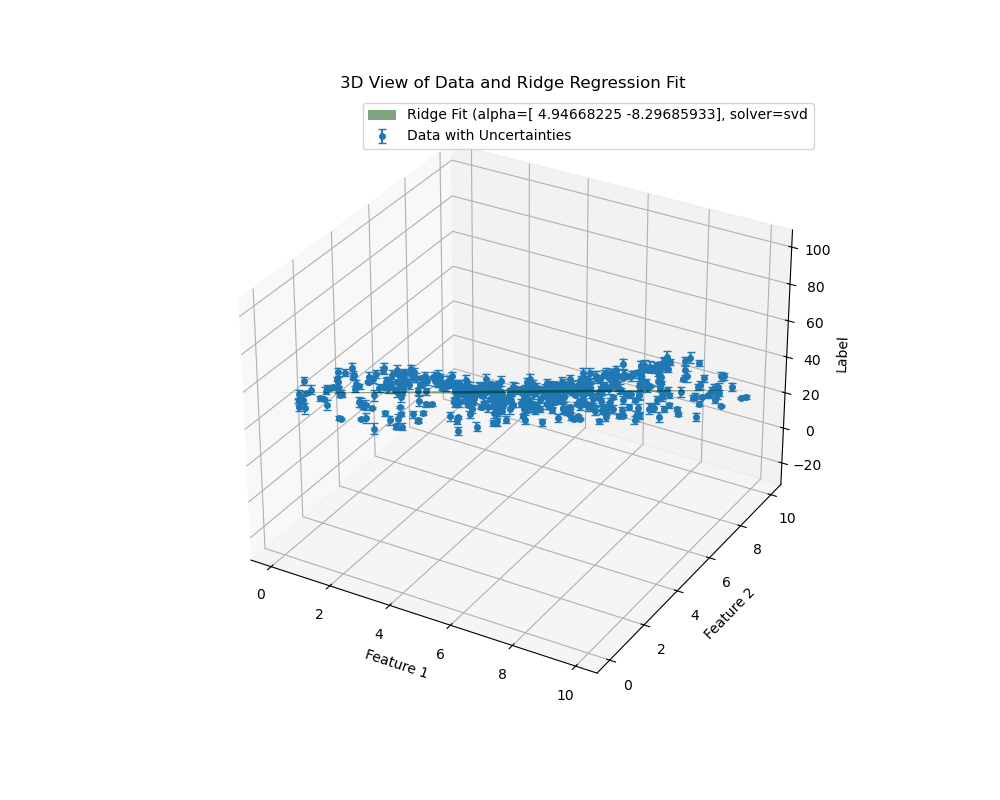


RidgeCV:
Cross-validated alpha: 1.0

The cross-validated alpha from RidgeCV ( 1.0 ) is close to one of the values explored in GridSearchCV ( 1.0 ), suggesting some agreement between the two methods for hyperparameter selection.


In [9]:
# Part 4
%matplotlib widget 

r_p = {'alpha': [0.05, 0.1, 0.2, 0.5, 1.0], 'solver': ['svd', 'lsqr']}
ridge = Ridge()
g_s = GridSearchCV(ridge, r_p, cv=5, scoring='neg_mean_squared_error')
g_s.fit(X, y, sample_weight=1/yerr**2)

print("\nGridSearchCV for Ridge Regression:")
print("Best parameters:", g_s.best_params_)
print("Best score (negative MSE):", g_s.best_score_)

b_r = g_s.best_estimator_
y_p_r_grid = b_r.predict(Xgrid)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.errorbar(X[:, 0], X[:, 1], y, zerr=yerr, fmt='o', markersize=4, capsize=3, label='Data with Uncertainties')
X1g, X2g = np.meshgrid(x1_grid, x2_grid)
Yg_ridge = b_r.predict(np.c_[X1g.ravel(), X2g.ravel()]).reshape(X1g.shape)
surf_ridge = ax.plot_surface(X1g, X2g, Yg_ridge, color='green', alpha=0.5, label=f'Ridge Fit (alpha={b_r.coef_}, solver={b_r.solver}')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Label')
ax.set_title('3D View of Data and Ridge Regression Fit')
ax.legend()
plt.show()

# RidgeCV
r_cv = RidgeCV(alphas=r_p['alpha'], cv=5)
r_cv.fit(X, y, sample_weight=1/yerr**2)
print("\nRidgeCV:")
print("Cross-validated alpha:", r_cv.alpha_)

print("\nThe cross-validated alpha from RidgeCV (", r_cv.alpha_, ") is close to one of the values explored in GridSearchCV (", g_s.best_params_['alpha'], "), suggesting some agreement between the two methods for hyperparameter selection.")


C:\Users\jeell\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


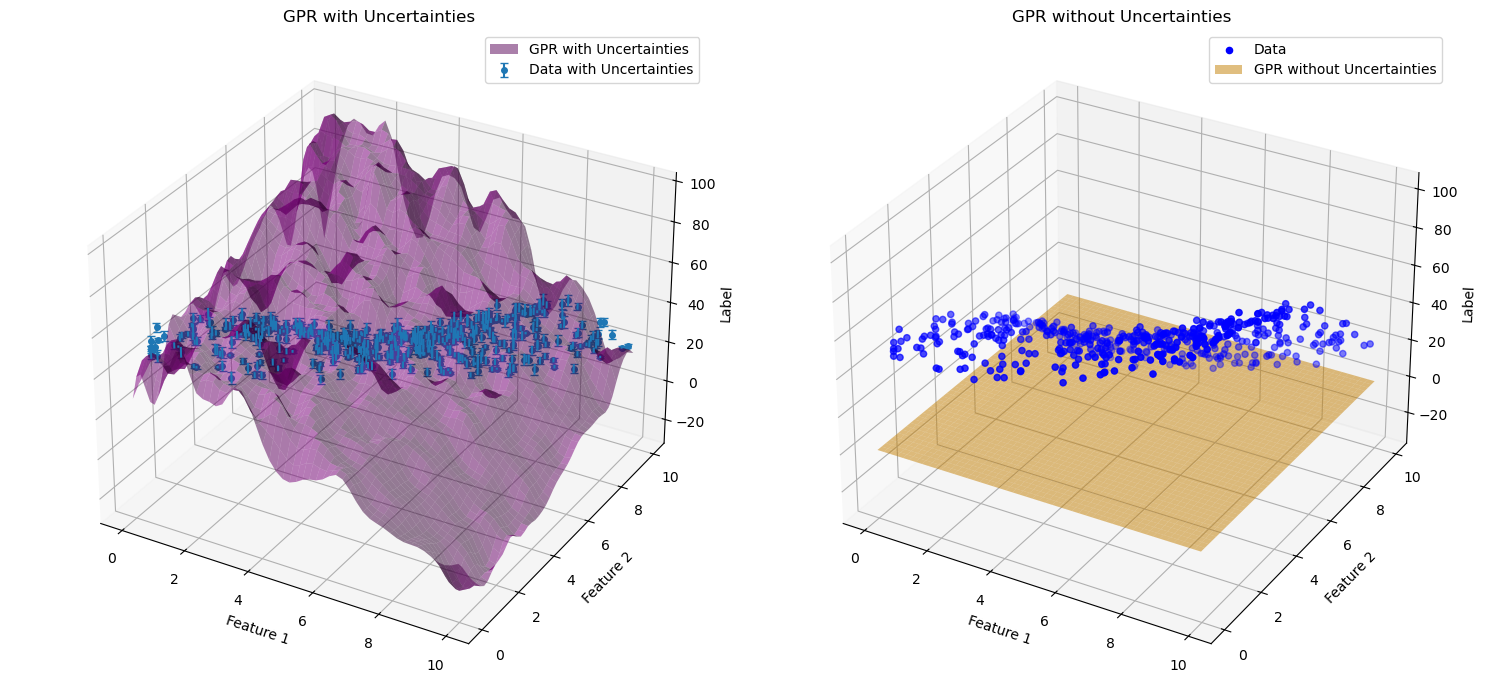


The GPR model, provides a better fit than linear models especially the one including uncertainites.


In [11]:
# Part 5
%matplotlib widget 

kernel = RBF()
gpr_with_err = GaussianProcessRegressor(kernel=kernel, alpha=(yerr / y)**2)
gpr_with_err.fit(X, y)
y_pred_gpr_err, sigma_gpr_err = gpr_with_err.predict(Xgrid, return_std=True)

gpr_no_err = GaussianProcessRegressor(kernel=kernel, alpha=1e-10)  # Small alpha to effectively ignore uncertainties
gpr_no_err.fit(X, y)
y_pred_gpr_no_err, sigma_gpr_no_err = gpr_no_err.predict(Xgrid, return_std=True)

fig = plt.figure(figsize=(15, 7))

ax1 = fig.add_subplot(121, projection='3d')
ax1.errorbar(X[:, 0], X[:, 1], y, zerr=yerr, fmt='o', markersize=4, capsize=3, label='Data with Uncertainties')
X1g, X2g = np.meshgrid(x1_grid, x2_grid)
Yg_gpr_err = y_pred_gpr_err.reshape(X1g.shape)
surf_gpr_err = ax1.plot_surface(X1g, X2g, Yg_gpr_err, color='purple', alpha=0.5, label='GPR with Uncertainties')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_zlabel('Label')
ax1.set_title('GPR with Uncertainties')
ax1.legend()

ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(X[:, 0], X[:, 1], y, label='Data', color='blue')
X1g, X2g = np.meshgrid(x1_grid, x2_grid)
Yg_gpr_no_err = y_pred_gpr_no_err.reshape(X1g.shape)
surf_gpr_no_err = ax2.plot_surface(X1g, X2g, Yg_gpr_no_err, color='orange', alpha=0.5, label='GPR without Uncertainties')
ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_zlabel('Label')
ax2.set_title('GPR without Uncertainties')
ax2.legend()

plt.tight_layout()
plt.show()

print("\nThe GPR model, provides a better fit than linear models especially the one including uncertainites.")



Polynomial Regression (Degree 4):
Best-fit coefficients: [ 1.46823267e-28  5.54313398e-01 -2.07866484e-01  2.86536907e-01
  2.93842380e-03 -7.82230112e-01  2.47603263e-02  2.45748271e-02
 -2.22233559e-02  9.68417971e-03 -9.95958746e-04 -1.12284370e-03
 -1.14462222e-03  2.10142159e-03 -1.08539159e-03]


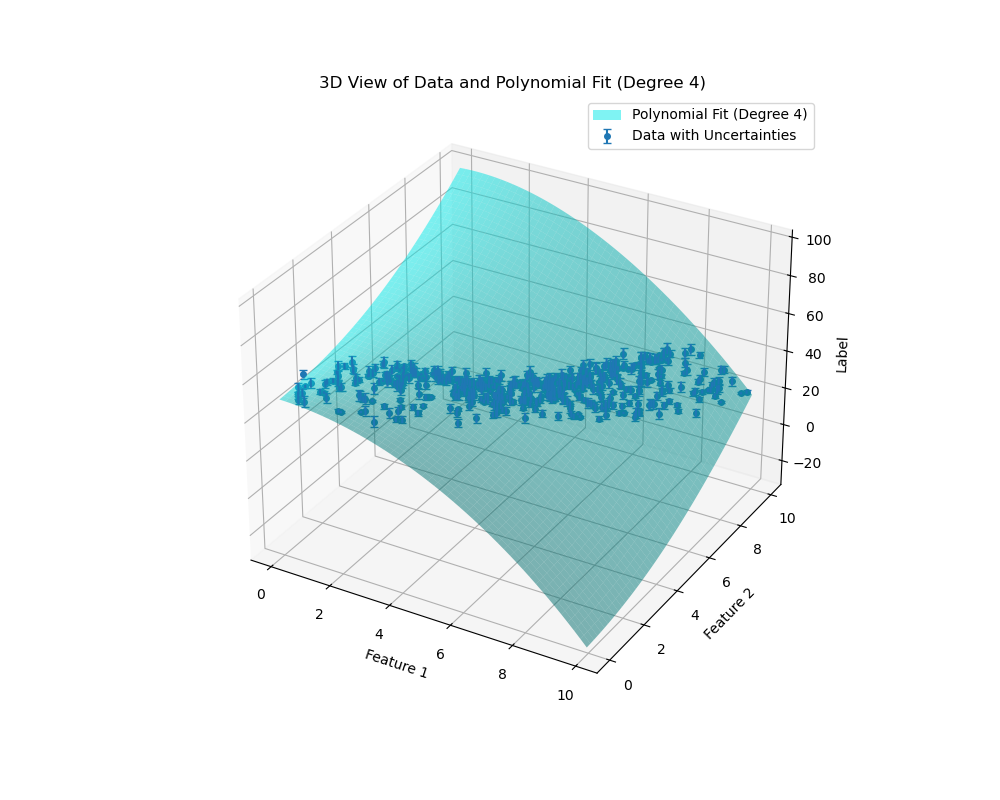


The 4th degree polynomial fit appears better than the linear model and is smoother over all than the GBR


In [13]:
# Part 6
%matplotlib widget 

degree = 4
poly = PolynomialFeatures(degree)
X_p = poly.fit_transform(X)

p_m = l_m.LinearRegression()
p_m.fit(X_p, y, sample_weight=1/yerr**2)

print("\nPolynomial Regression (Degree 4):")
print("Best-fit coefficients:", p_m.coef_)

Xgrid_p = poly.transform(Xgrid)
y_pred_p = p_m.predict(Xgrid_p)

# Interactive visualization of polynomial fit
# %matplotlib widget
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.errorbar(X[:, 0], X[:, 1], y, zerr=yerr, fmt='o', markersize=4, capsize=3, label='Data with Uncertainties')
X1g, X2g = np.meshgrid(x1_grid, x2_grid)
Yg_p = y_pred_p.reshape(X1g.shape)
surf_poly = ax.plot_surface(X1g, X2g, Yg_p, color='cyan', alpha=0.5, label=f'Polynomial Fit (Degree {degree})')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Label')
ax.set_title(f'3D View of Data and Polynomial Fit (Degree {degree})')
ax.legend()
plt.show()

print("\nThe 4th degree polynomial fit appears better than the linear model and is smoother over all than the GBR")


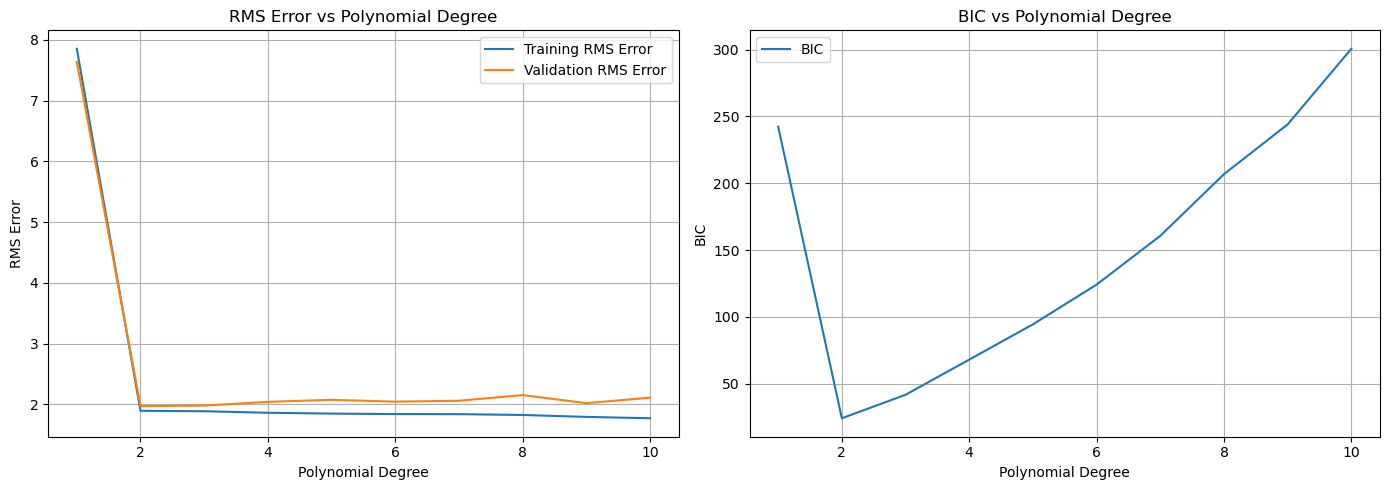


Optimal polynomial degree based on BIC: 2
Testing RMS Error with optimal polynomial degree (2): 1.9492


In [17]:
# Part 7
%matplotlib inline

X_train_val, X_test, y_train_val, y_test, yerr_train_val, yerr_test = train_test_split(
    X, y, yerr, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val, yerr_train, yerr_val = train_test_split(
    X_train_val, y_train_val, yerr_train_val, test_size=0.2, random_state=42
)

degrees = np.arange(1, 11)
train_rms_errors = []
val_rms_errors = []
bic_values = []
n_train = len(y_train)
n_val = len(y_val)
n_features = X.shape[1]

for degree in degrees:
    poly = PolynomialFeatures(degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)

    model = l_m.LinearRegression()
    model.fit(X_train_poly, y_train, sample_weight=1/yerr_train**2)

    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

    train_rms_errors.append(train_rmse)
    val_rms_errors.append(val_rmse)

    # Calculate BIC
    n_params = model.coef_.shape[0]
    rss = np.sum((y_val - y_val_pred)**2 / yerr_val**2)
    bic = n_val * np.log(rss / n_val) + n_params * np.log(n_val)
    bic_values.append(bic)

# Plotting rms errors and BIC
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(degrees, train_rms_errors, label='Training RMS Error')
axes[0].plot(degrees, val_rms_errors, label='Validation RMS Error')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('RMS Error')
axes[0].set_title('RMS Error vs Polynomial Degree')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(degrees, bic_values, label='BIC')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('BIC')
axes[1].set_title('BIC vs Polynomial Degree')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

optimal_degree_bic = degrees[np.argmin(bic_values)]
print(f"\nOptimal polynomial degree based on BIC: {optimal_degree_bic}")

# Train on all training data with the optimal degree
optimal_poly = PolynomialFeatures(optimal_degree_bic)
X_train_val_poly = optimal_poly.fit_transform(X_train_val)
optimal_model = l_m.LinearRegression()
optimal_model.fit(X_train_val_poly, y_train_val, sample_weight=1/yerr_train_val**2)

# Predict on the held-out test set
X_test_poly = optimal_poly.transform(X_test)
y_test_pred = optimal_model.predict(X_test_poly)

# Compute the testing rms error
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print(f"Testing RMS Error with optimal polynomial degree ({optimal_degree_bic}): {test_rmse:.4f}")